Epoch 1/20


C:\Users\DELL\AppData\Local\Temp\ipykernel_13300\111608584.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['moving_avg'] = data['price'].rolling(window=5).mean().fillna(method='bfill')
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0830 - val_loss: 0.0481
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0104 - val_loss: 0.0334
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0054 - val_loss: 0.0263
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0041 - val_loss: 0.0467
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0046 - val_loss: 0.0250
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0041 - val_loss: 0.0386
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0035 - val_loss: 0.0252
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0038 - val_loss: 0.0335
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0038 - val_loss: 0.0245
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0032 - val_loss: 0.0284
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0034 - val_loss: 0.0243
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0032 - val_loss: 0.0238
Epoch 13/20

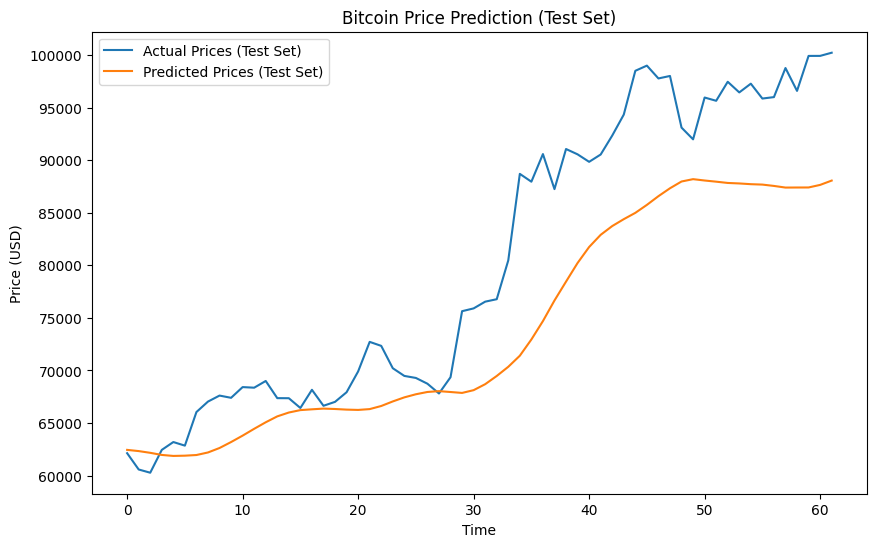

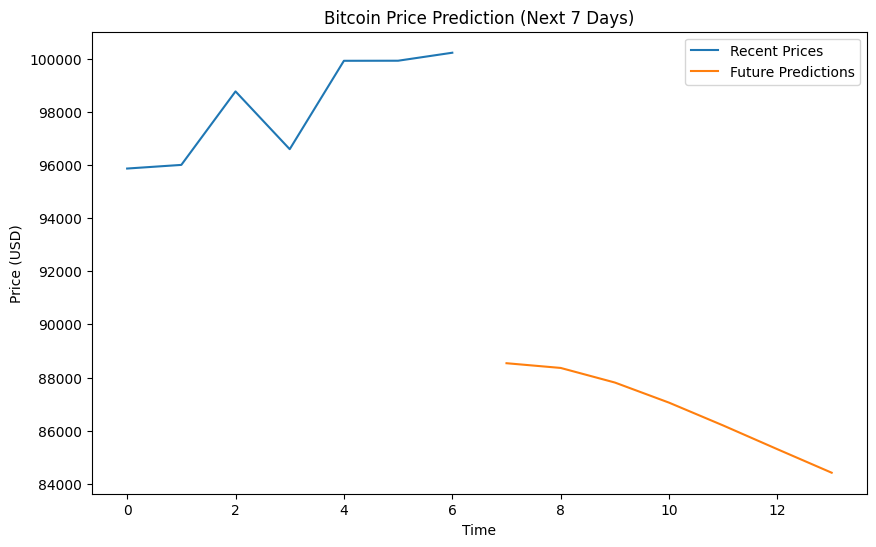

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Function to fetch Bitcoin data
def fetch_live_bitcoin_data(period='1y', interval='1d'):
    """
    Fetch live Bitcoin data from Yahoo Finance.
    :param period: Period of historical data (e.g., '1y', '6mo').
    :param interval: Data interval (e.g., '1d' for daily).
    :return: DataFrame with timestamp and price columns.
    """
    ticker = yf.Ticker("BTC-USD")
    data = ticker.history(period=period, interval=interval)
    data.reset_index(inplace=True)
    data = data[['Date', 'Close', 'Volume']]
    data.rename(columns={'Date': 'timestamp', 'Close': 'price', 'Volume': 'volume'}, inplace=True)
    return data


# Function to preprocess data and add features
def preprocess_data(data, look_back=60):
    """
    Preprocess data for LSTM and add technical indicators.
    :param data: DataFrame with 'price' column.
    :param look_back: Number of past steps to use for prediction.
    :return: Scaled data, input/output sequences, and scaler.
    """
    # Add moving average as a feature
    data['moving_avg'] = data['price'].rolling(window=5).mean().fillna(method='bfill')
    
    # Scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data[['scaled_price', 'scaled_volume', 'scaled_moving_avg']] = scaler.fit_transform(
        data[['price', 'volume', 'moving_avg']]
    )
    
    # Generate sequences for LSTM
    features = data[['scaled_price', 'scaled_volume', 'scaled_moving_avg']].values
    X, y = [], []
    for i in range(look_back, len(features)):
        X.append(features[i-look_back:i])
        y.append(features[i, 0])  # Use price as the target
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler


# Function to build the LSTM model
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.
    :param input_shape: Shape of input data.
    :return: Compiled model.
    """
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Function to predict the next 7 days
def predict_next_7_days(model, data, scaler, look_back=60):
    """
    Predict the next 7 days of Bitcoin prices.
    :param model: Trained LSTM model.
    :param data: DataFrame with recent prices.
    :param scaler: Scaler used during preprocessing.
    :param look_back: Number of past steps used for prediction.
    :return: List of predicted prices.
    """
    predictions = []
    input_seq = data[['scaled_price', 'scaled_volume', 'scaled_moving_avg']].values[-look_back:]
    input_seq = input_seq.reshape(1, input_seq.shape[0], input_seq.shape[1])

    for _ in range(7):
        scaled_prediction = model.predict(input_seq)
        prediction = scaler.inverse_transform([[scaled_prediction[0][0], 0, 0]])[0, 0]
        predictions.append(prediction)
        
        # Update input sequence with the new prediction
        new_input = np.array([scaled_prediction[0][0], data['scaled_volume'].iloc[-1], data['scaled_moving_avg'].iloc[-1]])
        input_seq = np.append(input_seq[0, 1:], [new_input], axis=0).reshape(1, -1, 3)

    return predictions


# Main Execution
if __name__ == "__main__":
    # Fetch data
    bitcoin_data = fetch_live_bitcoin_data(period='1y', interval='1d')

    # Preprocess data
    look_back = 60
    X, y, scaler = preprocess_data(bitcoin_data, look_back)

    # Split data into training and testing sets
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build and train the model
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate model performance
    predicted_test = model.predict(X_test)
    predicted_test = scaler.inverse_transform(np.column_stack([predicted_test, np.zeros((len(predicted_test), 2))]))[:, 0]
    actual_test = scaler.inverse_transform(np.column_stack([y_test, np.zeros((len(y_test), 2))]))[:, 0]

    mae = mean_absolute_error(actual_test, predicted_test)
    rmse = np.sqrt(mean_squared_error(actual_test, predicted_test))
    print(f"Mean Absolute Error on Test Set: {mae}")
    print(f"Root Mean Squared Error on Test Set: {rmse}")

    # Predict the next 7 days
    future_predictions = predict_next_7_days(model, bitcoin_data, scaler, look_back)
    print(f"Predicted Bitcoin prices for the next 7 days: {future_predictions}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(actual_test, label="Actual Prices (Test Set)")
    plt.plot(predicted_test, label="Predicted Prices (Test Set)")
    plt.legend()
    plt.title("Bitcoin Price Prediction (Test Set)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.show()

    # Plot future predictions
    recent_prices = bitcoin_data['price'].iloc[-7:].values
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(recent_prices)), recent_prices, label="Recent Prices")
    plt.plot(range(len(recent_prices), len(recent_prices) + 7), future_predictions, label="Future Predictions")
    plt.legend()
    plt.title("Bitcoin Price Prediction (Next 7 Days)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.show()
